# Corona

attacking montecarlo single-electron events at 2.5MeV



In [1]:
%matplotlib inline

from __future__ import print_function
import abc
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

from   collections import namedtuple
from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.reco.xy_algorithms import barycenter, corona

import os
import random
import tables as tb
import numpy  as np

NSIPM = 1792

------
## Test events
Read in using old PMap format, converted to a format to be passed to reconstruction method.

In [2]:
ic_data = os.path.join(os.environ['IC_DATA'])
nfile = ic_data + "Montecarlo/SE/hdf5_NEXT_NEW_se_1M_v0_08_07_0.h5"
erange_low = 0
erange_high = 10

In [3]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    #if(hasattr(l_X0, "__len__")):
    #    for xx,yy in zip(l_X0,l_Y0):
    #        mrk = Ellipse(xy=(xx,yy), width=4., height=4.)
    #        mrk.set_facecolor('b')
    #        ax1.add_artist(mrk)
    #else:
    #    mrk = Ellipse(xy=(l_X0,l_Y0), width=4., height=4.)
    #    mrk.set_facecolor('b')
    #    ax1.add_artist(mrk)
        
    # place a large red circle for reconstructed points
    #if(ept is not None):
    #    xpt = ept[0]*fscale - fshift*fscale
    #    ypt = ept[1]*fscale - fshift*fscale
    #    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    #    mrk.set_facecolor('r');
    #    ax1.add_artist(mrk);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [4]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
xs = DataSensor.X.values
ys = DataSensor.Y.values

# create (x,y) lists
_sipm_x = np.zeros(NSIPM)
_sipm_y = np.zeros(NSIPM)
for ID, x, y in zip(range(NSIPM), xs, ys):
    _sipm_x[ID] = x
    _sipm_y[ID] = y

In [5]:
nevts = erange_high - erange_low

# open the hdf5 file containing the PMaps.
fname = "{0}".format(nfile)
print("Opening file: {0}".format(fname))
fpmap = tb.open_file(fname,'r')
pmaps = fpmap.root.PMaps.PMaps
print(pmaps)

# set up the lists
tbl_T = []; tbl_E = [] 
tbl_X = []; tbl_Y = []; tbl_Q = []

# loop over all events.
rnum = 0                    # row number in table iteration
ev = 0                      # processed event number (starts at 0 and runs to nevts-1)
evtnum = pmaps[0]['event']  # event number from file
while(rnum < pmaps.nrows and ev < nevts):

    # Skip rows corresponding to event numbers outside of given range.
    if((evtnum < erange_low or evtnum > erange_high) and not (erange_low < 0 or erange_high < 0)):
        rnum += 1
        if(rnum < pmaps.nrows):
            evtnum = pmaps[rnum]['event']
        continue

    # Attempt to get all times, cathode energies, and anode values
    #  for one event.
    times = []
    cathodes = []
    anodes = []
    while(rnum < pmaps.nrows and pmaps[rnum]['event'] == evtnum):
        if(pmaps[rnum]['signal'] == b'S2'):
            times.append(pmaps[rnum]['time'])
            cathodes.append(pmaps[rnum]['cathode'])
            anodes.append(pmaps[rnum]['anode'])
        rnum += 1
        
    # convert to numpy arrays
    anodes = np.array(anodes)
    cathodes = np.array(cathodes)
    times = np.array(times)

    # if we had an S2 for this event, get the relevant information and add the event
    if(len(times) > 0):
        print("Had S2")
        
        # store the energies and times of each projection
        tbl_E.append(cathodes)
        tbl_T.append(times)
        
        # create lists of (x,y,q) for each projection and store
        evt_X = []; evt_Y = []; evt_Q = []
        for aa in anodes:
            ids = np.nonzero(aa)
            evt_X.append(_sipm_x[ids])
            evt_Y.append(_sipm_y[ids])
            evt_Q.append(aa[ids])
        tbl_X.append(evt_X)
        tbl_Y.append(evt_Y)
        tbl_Q.append(evt_Q)

    # set to the next event
    if(rnum < pmaps.nrows):
        print("Processed event {0} with rnum {1} of {2} rows.".format(evtnum, rnum, pmaps.nrows))
        evtnum = pmaps[rnum]['event']
        
# convert to arrays
tbl_X = np.array(tbl_X)
tbl_Y = np.array(tbl_Y)
tbl_Q = np.array(tbl_Q)

Opening file: /Users/alej/Desktop/IC_DATA/Montecarlo/SE/hdf5_NEXT_NEW_se_1M_v0_08_07_0.h5
/PMaps/PMaps (Table(144354,), shuffle, zlib(9)) 'PMaps'
Had S2
Processed event 2 with rnum 34 of 144354 rows.
Had S2
Processed event 3 with rnum 94 of 144354 rows.
Had S2
Processed event 4 with rnum 142 of 144354 rows.
Had S2
Processed event 5 with rnum 190 of 144354 rows.
Had S2
Processed event 9 with rnum 258 of 144354 rows.
Had S2
Processed event 10 with rnum 324 of 144354 rows.


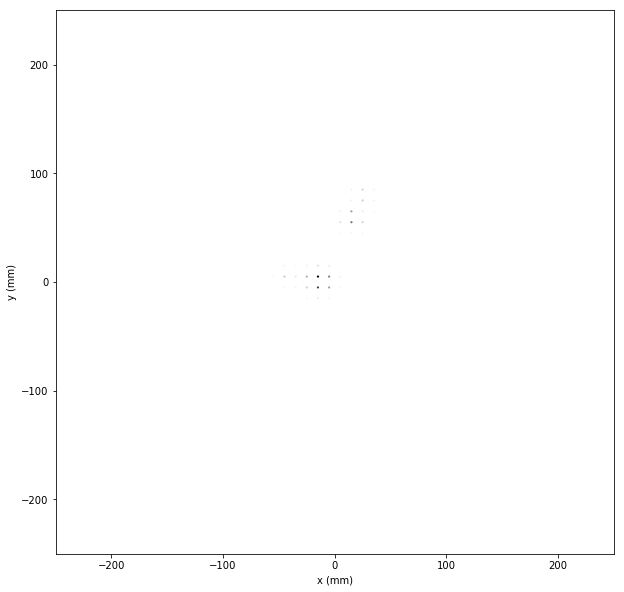

In [6]:
# plot a test projection
t_evt = 0; t_proj = 14
t_X = tbl_X[t_evt][t_proj]; t_Y = tbl_Y[t_evt][t_proj]
t_Q = tbl_Q[t_evt][t_proj]
t_Q /= np.max(t_Q)

plot_test_event(t_X,t_Y,t_Q)

-------
# Reconstruction
Reconstruct 1 event (produce hit collection).  Later Paolina can be run on the hit collection.

In [7]:
# event to be reconstructed
r_evt = 4

In [8]:
# reconstruction objects (already defined)
class Event:
    def __init__(self):
        self.evt  = -1
        self.time = -1

    def __str__(self):
        s = "{0}Event\n{0}".format("#"*20 + "\n")
        for attr in self.__dict__:
            s += "{}: {}\n".format(attr, getattr(self, attr))
        return s

    def copy(self, other):
        assert isinstance(other, Event)
        for attr in other.__dict__:
            setattr(self, attr, copy.deepcopy(getattr(other, attr)))

    @abc.abstractmethod
    def store(self, *args, **kwargs):
        pass

class Hit:
    def __init__(self):
        self.Npeak = -1
        self.X     = -1e12
        self.Y     = -1e12
        self.R     = -1e12
        self.Phi   = -1e12
        self.Z     = -1
        self.E     = -1
        self.Q     = -1
        self.Nsipm = -1

class HitCollection(list, Event):
    def __init__(self):
        list .__init__(self)
        Event.__init__(self)

    def store(self, row):
        for hit in self:
            row["event"] = self.evt
            row["time" ] = self.time

            row["npeak"] = hit.Npeak
            row["X"    ] = hit.X
            row["Y"    ] = hit.Y
            row["Z"    ] = hit.Z
            row["R"    ] = hit.R
            row["Phi"  ] = hit.Phi
            row["Nsipm"] = hit.Nsipm
            row["Q"    ] = hit.Q
            row["E"    ] = hit.E
            row["Ecorr"] = hit.Ecorr

            row.append()

# cluster named tuple (make the class using the namedtuple function)
Cluster = namedtuple('Cluster', 'Q X Y Xrms Yrms Nsipm')

In [9]:
reco_algorithm = corona
# different than Gonzalo's because we're using our test setup
def compute_xy_position(xs,ys,Qs):
    return reco_algorithm(xs, ys, Qs)

In [10]:
# split the energy across the clusters
def split_energy(Es, clusters):
    qtot = np.sum([cl.Q for cl in clusters])
    return [(Es*cl.Q/qtot) for cl in clusters]

/Users/alej/miniconda/envs/IC3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


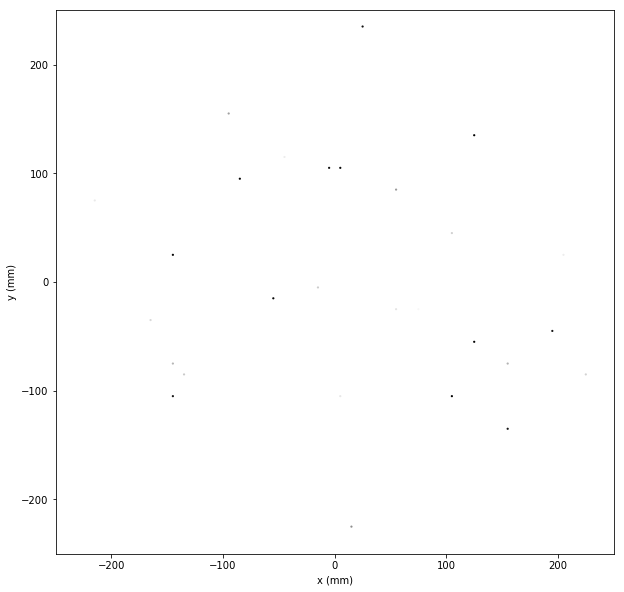

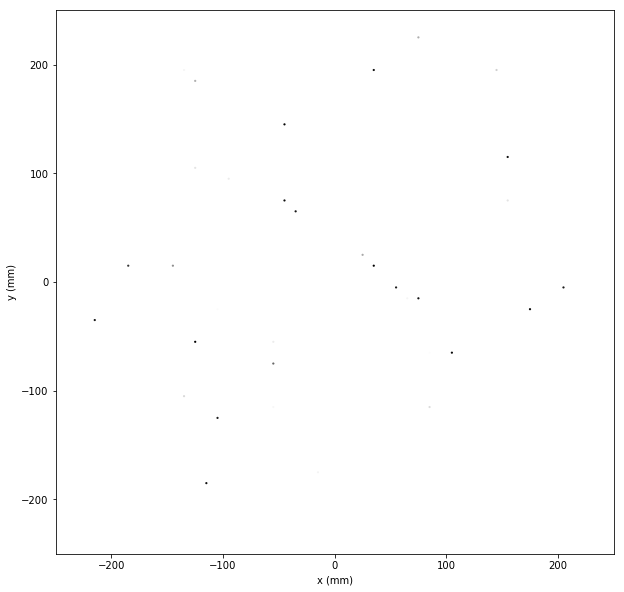

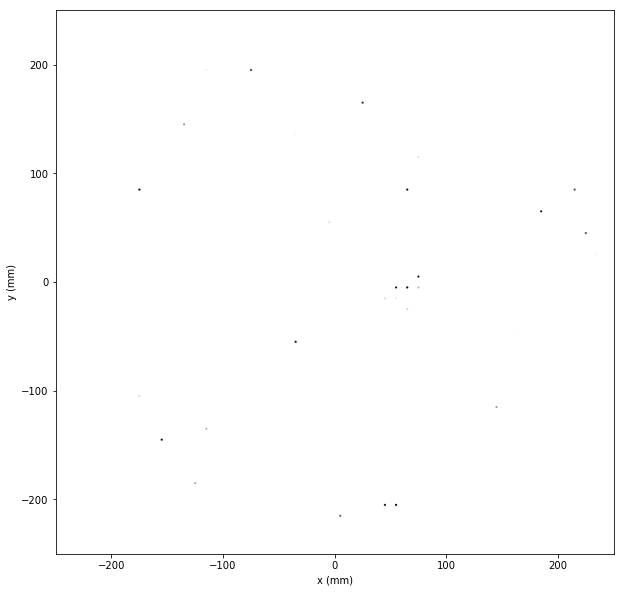

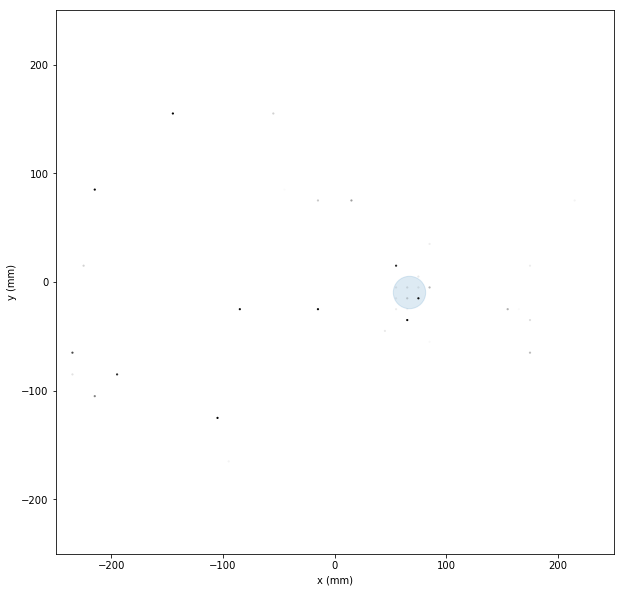

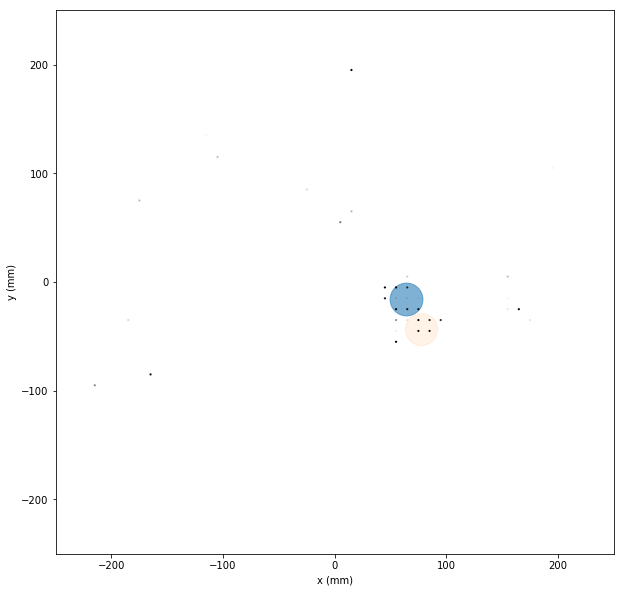

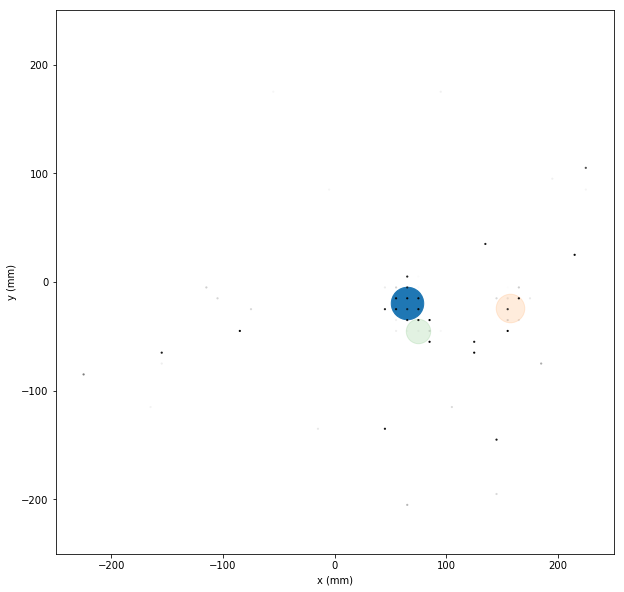

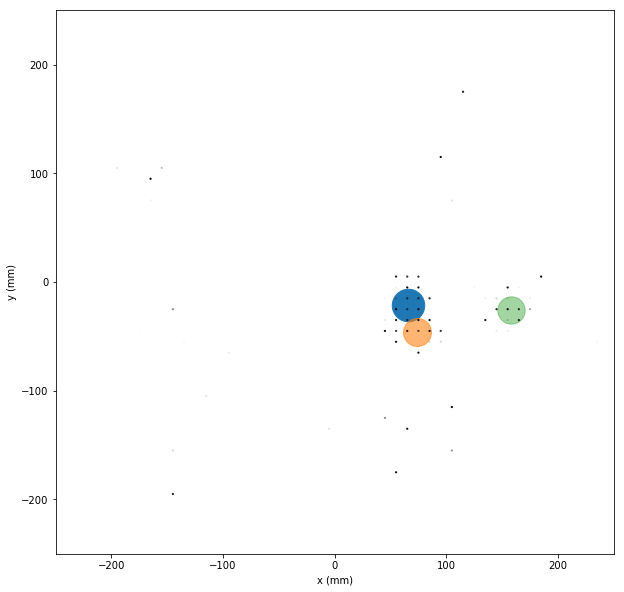

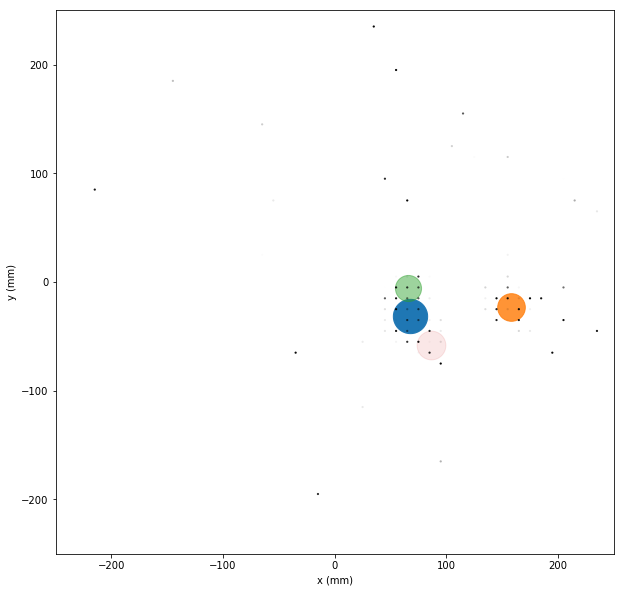

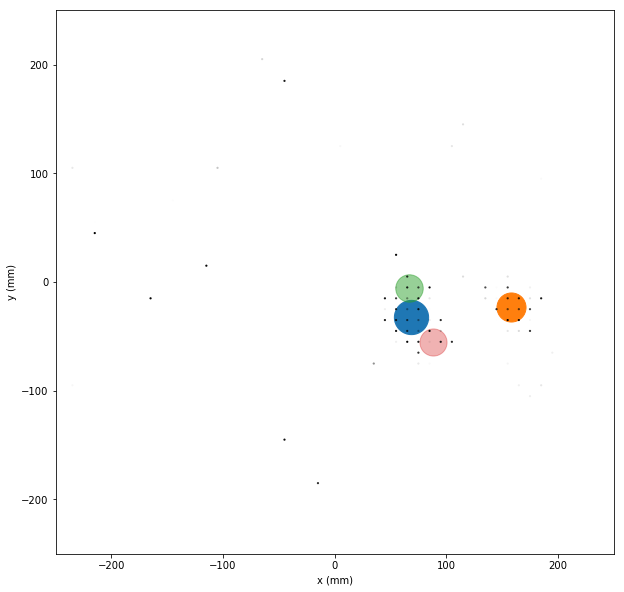

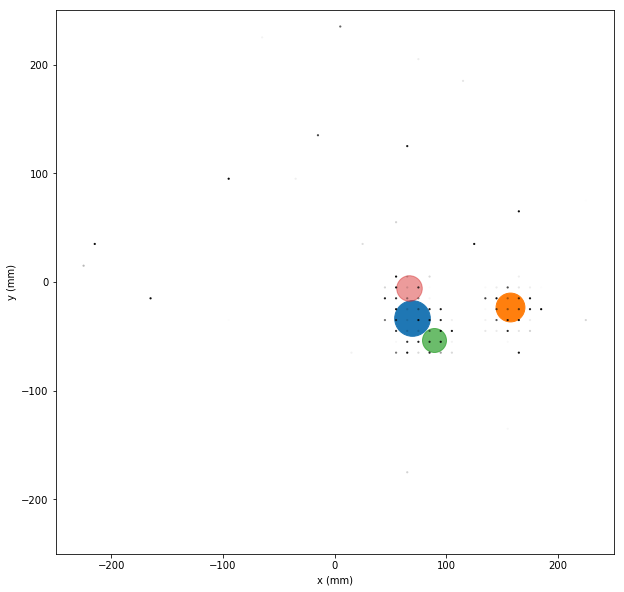

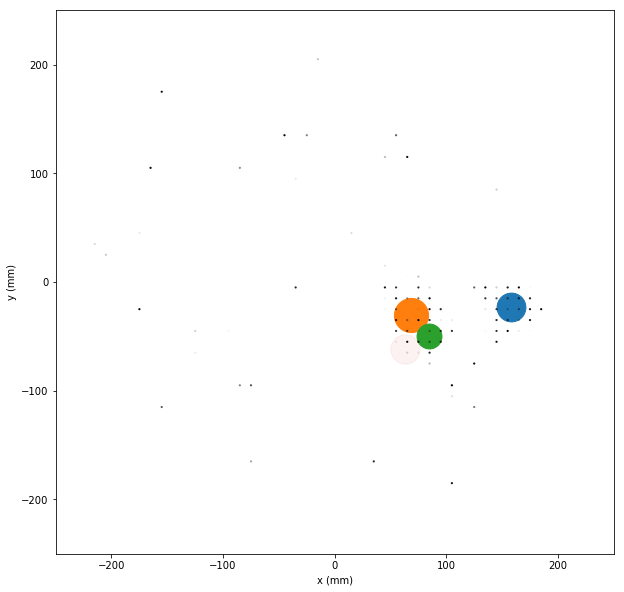

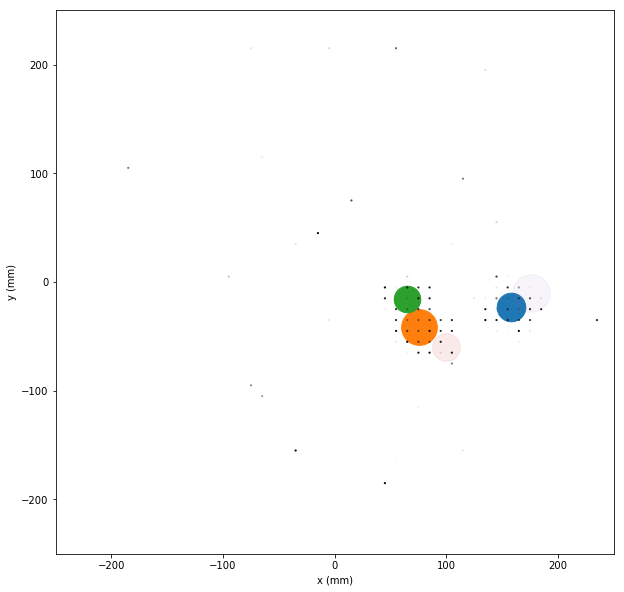

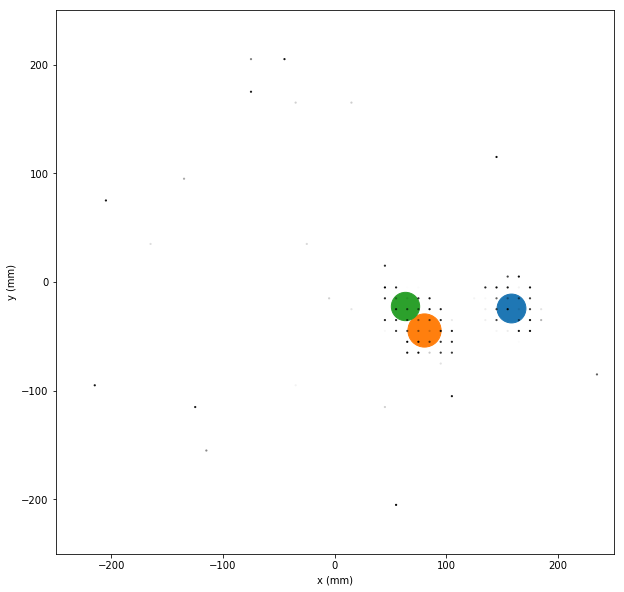

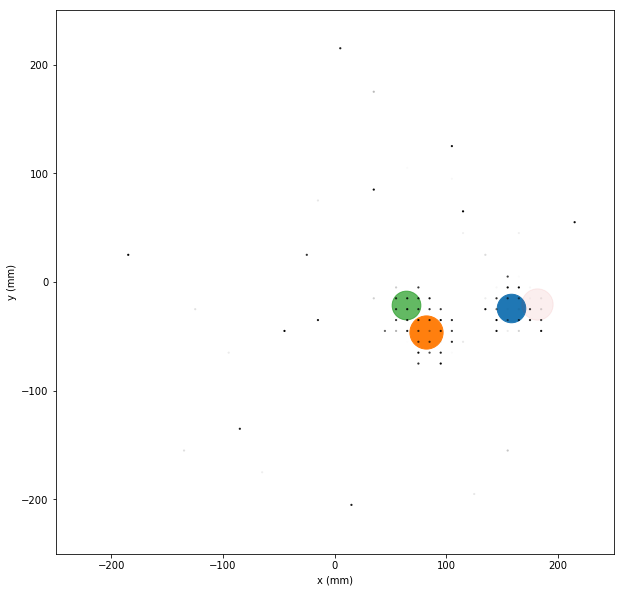

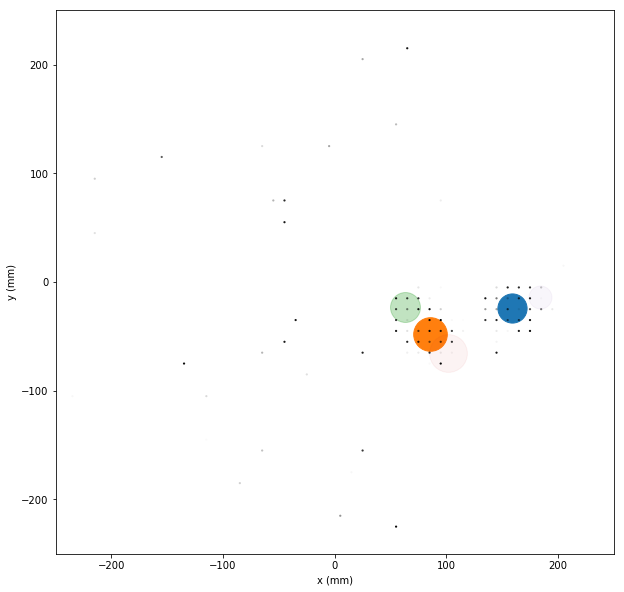

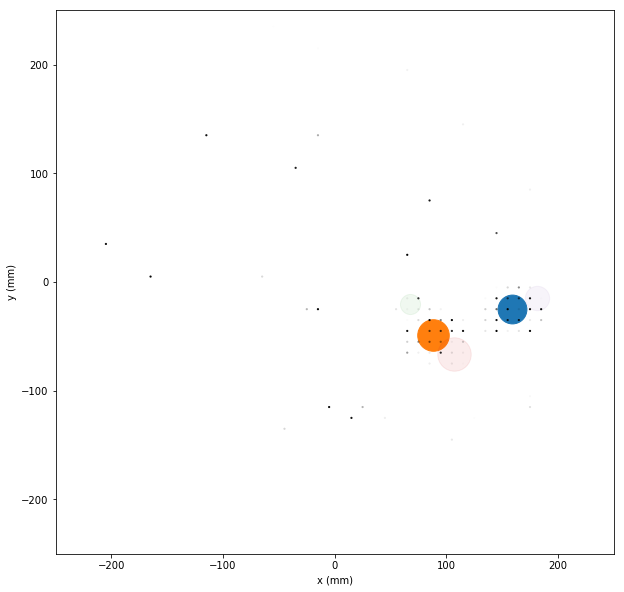

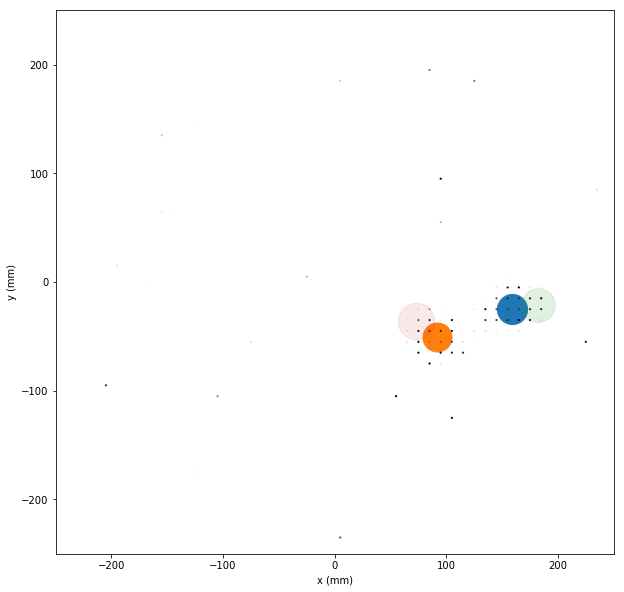

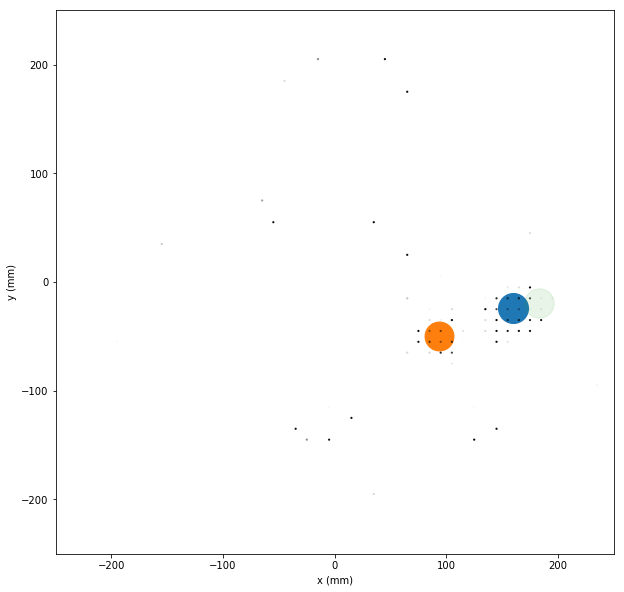

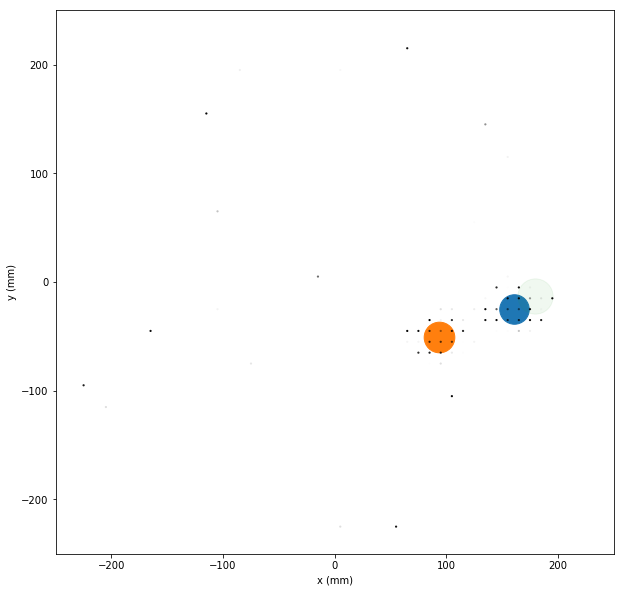

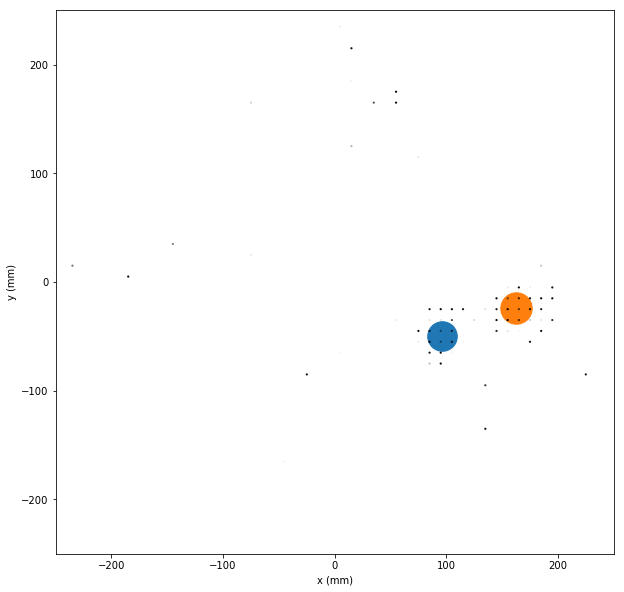

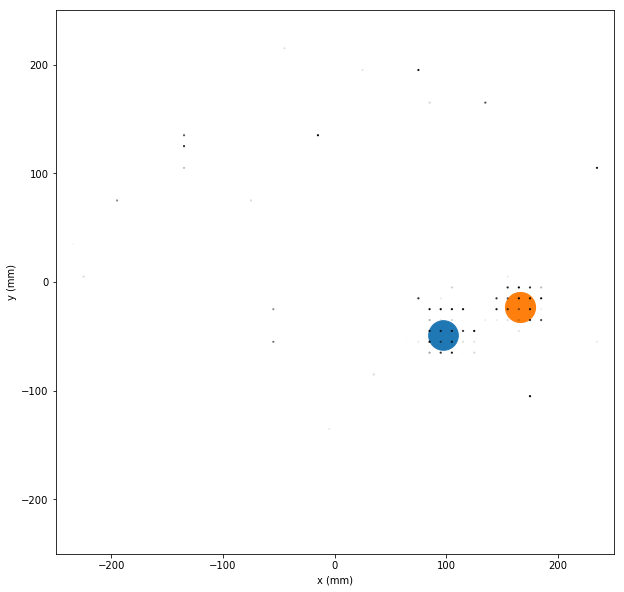

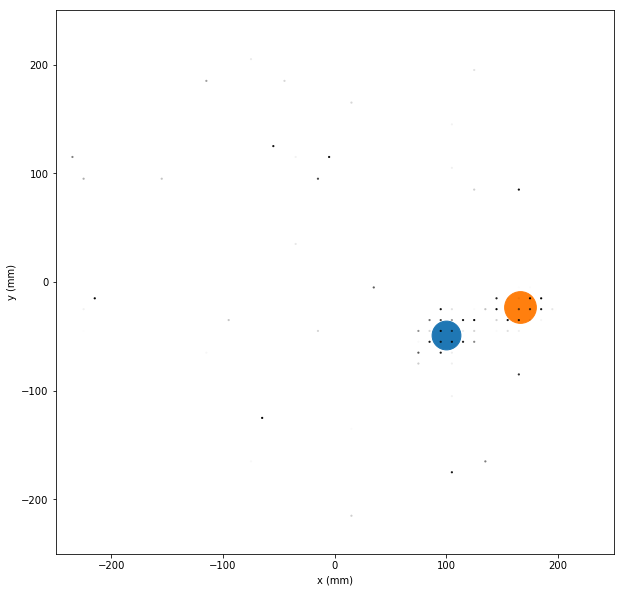

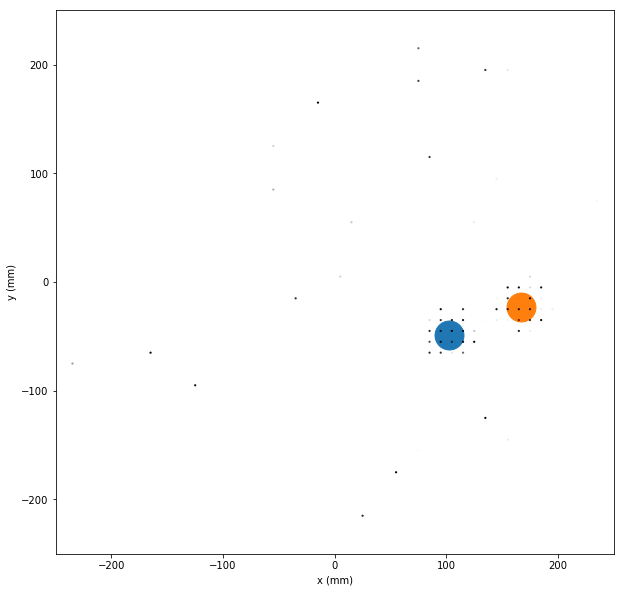

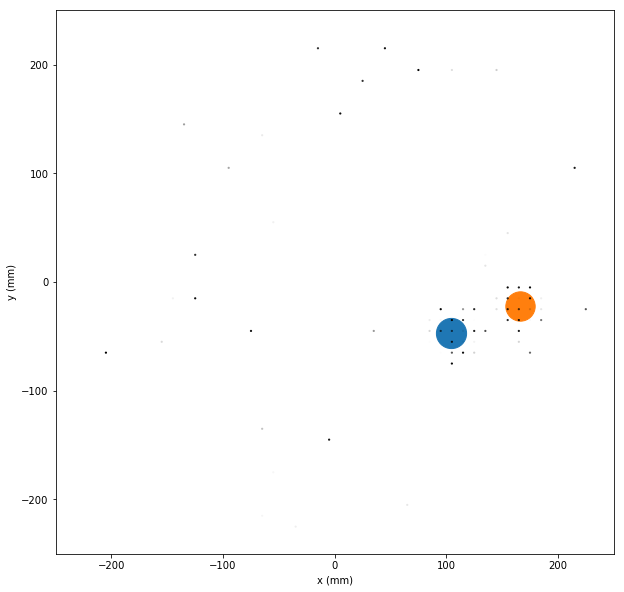

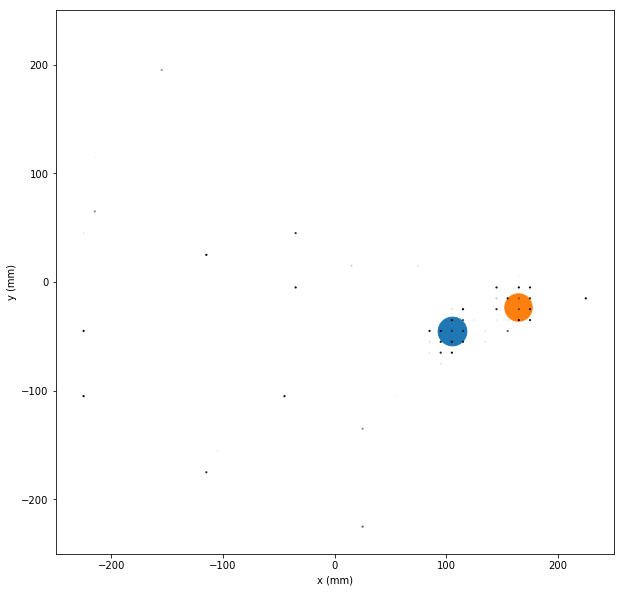

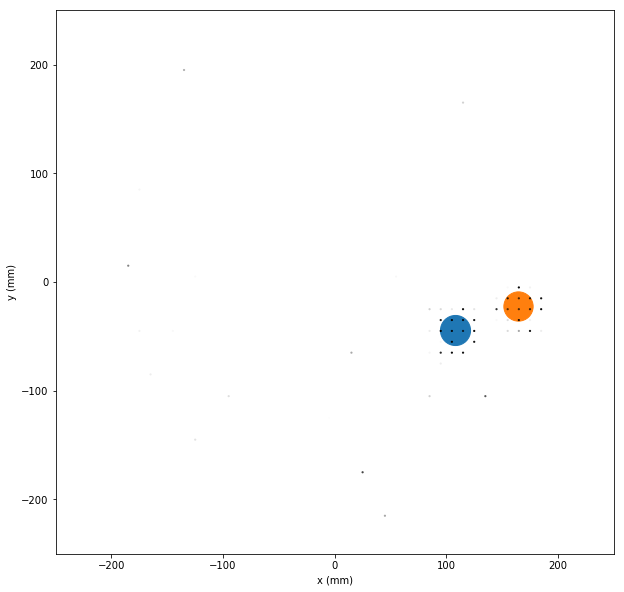

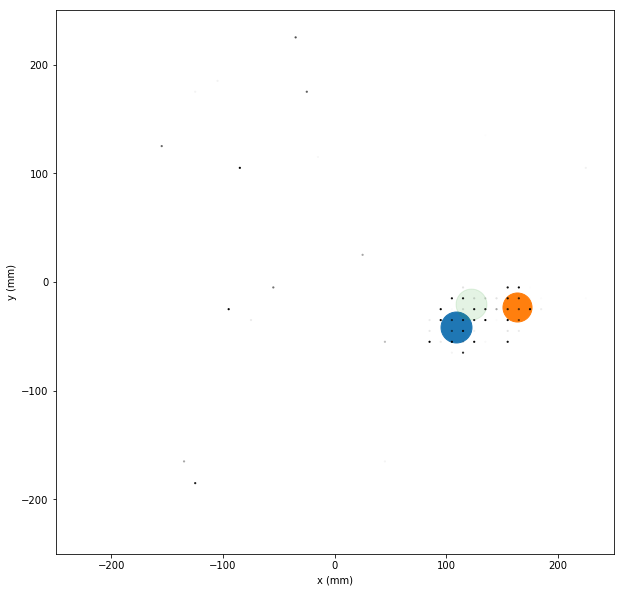

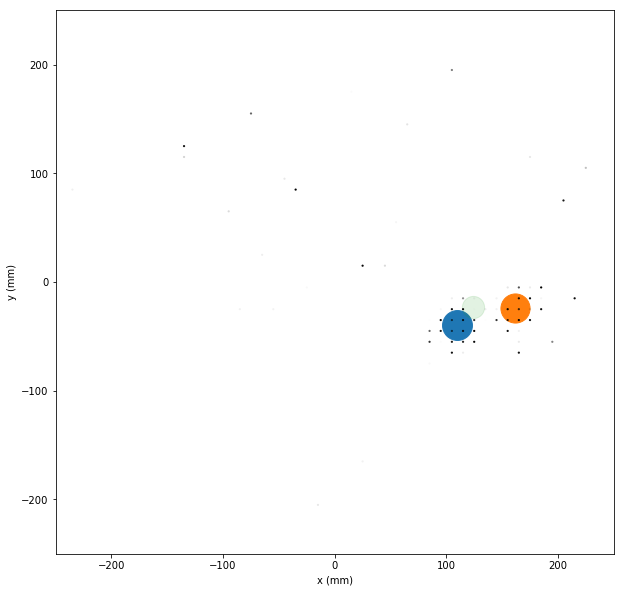

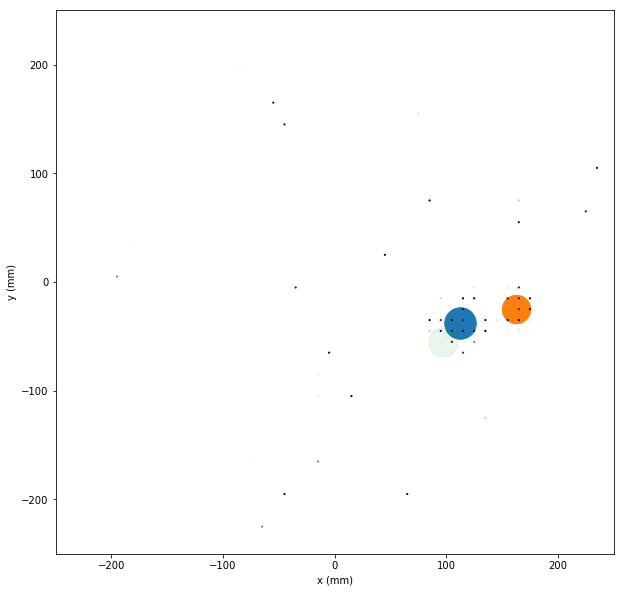

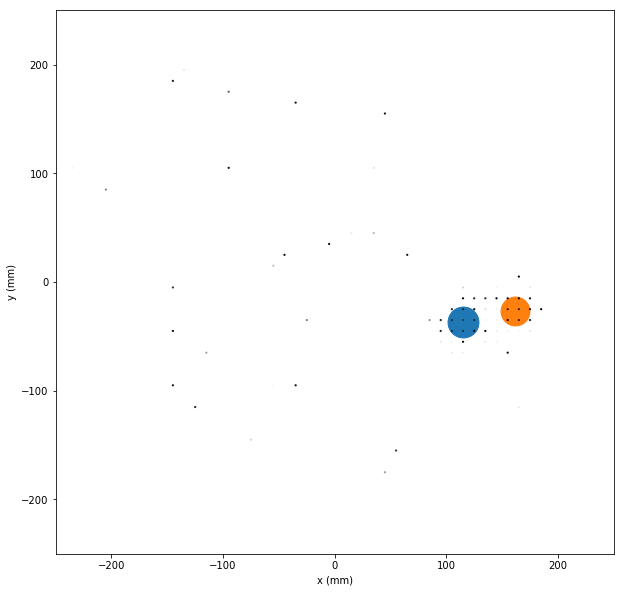

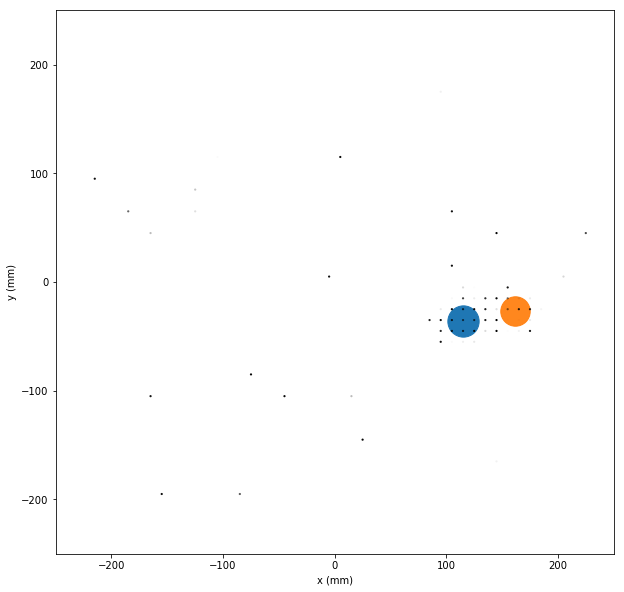

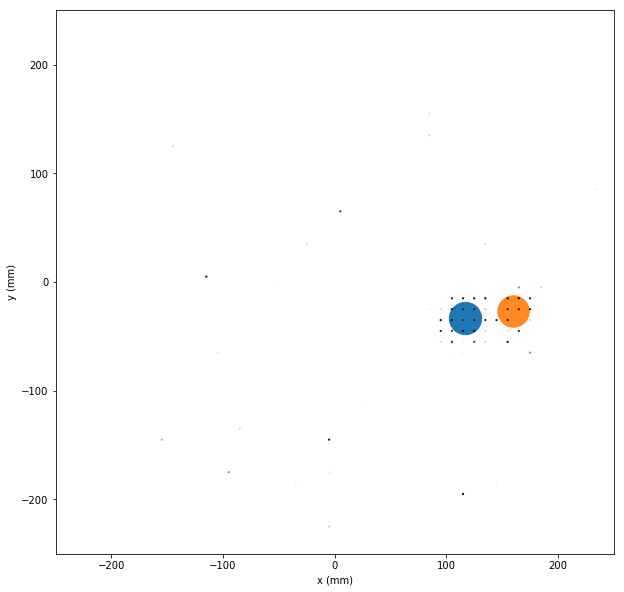

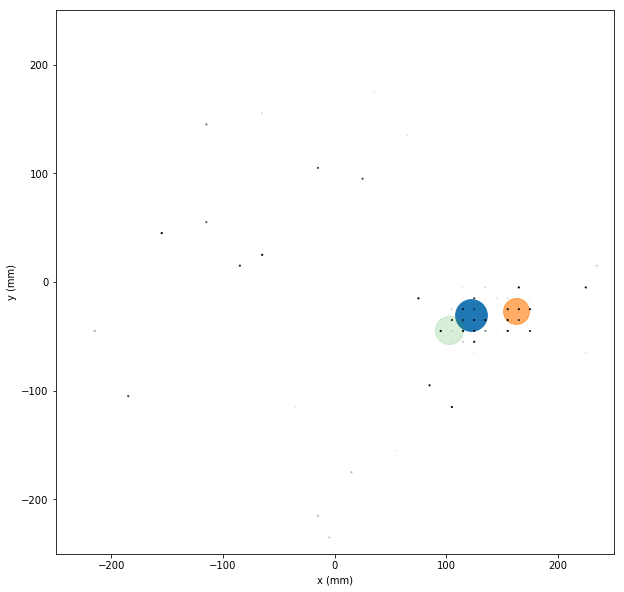

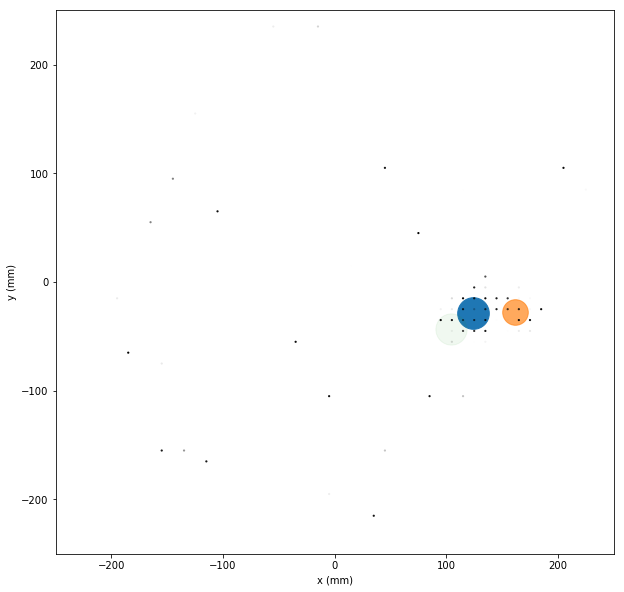

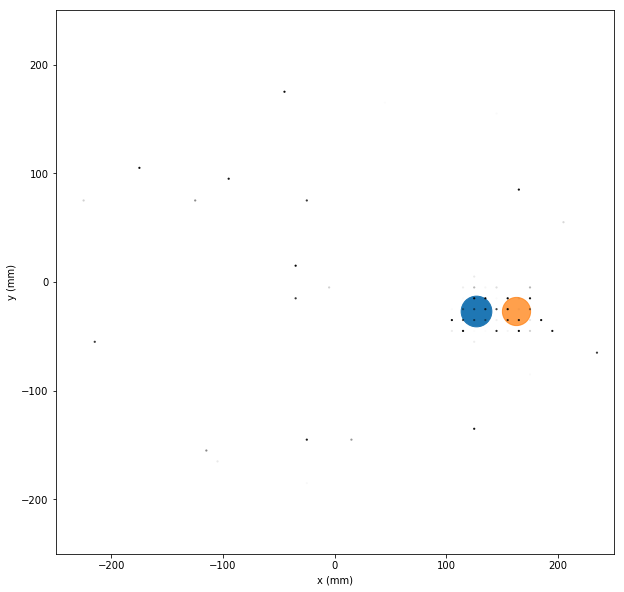

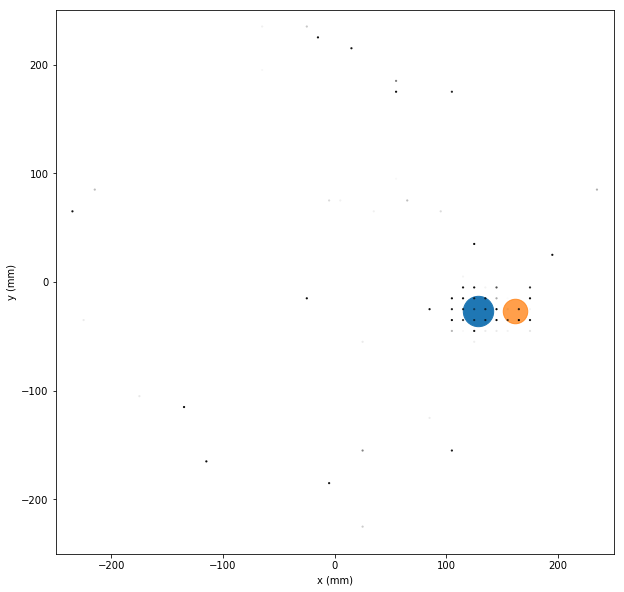

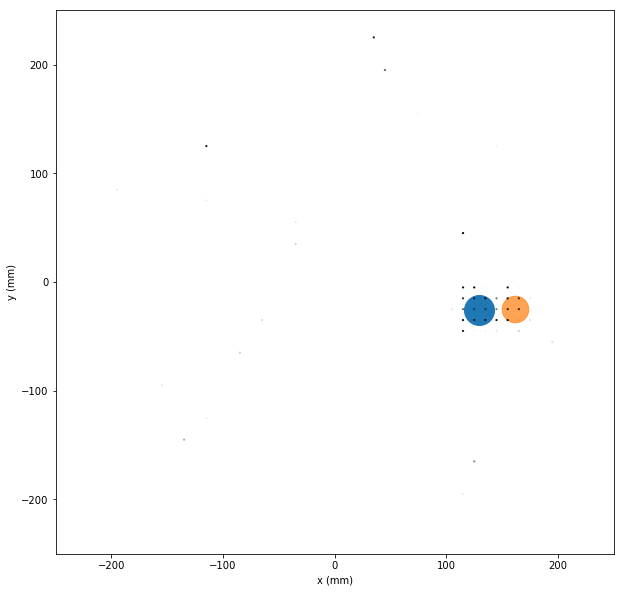

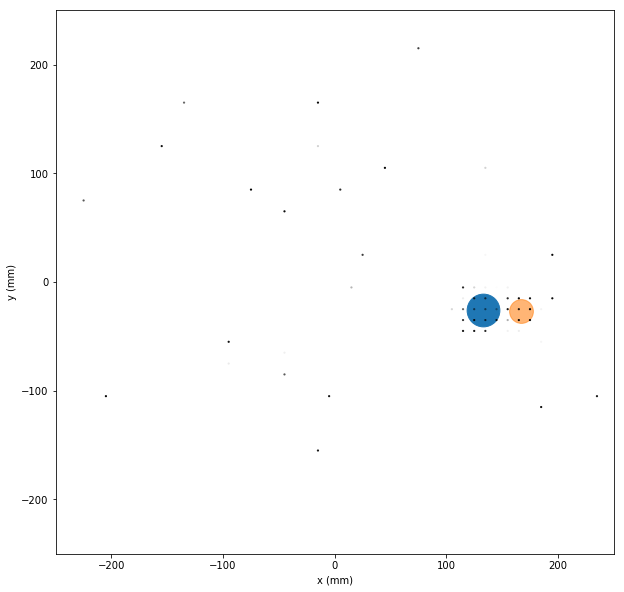

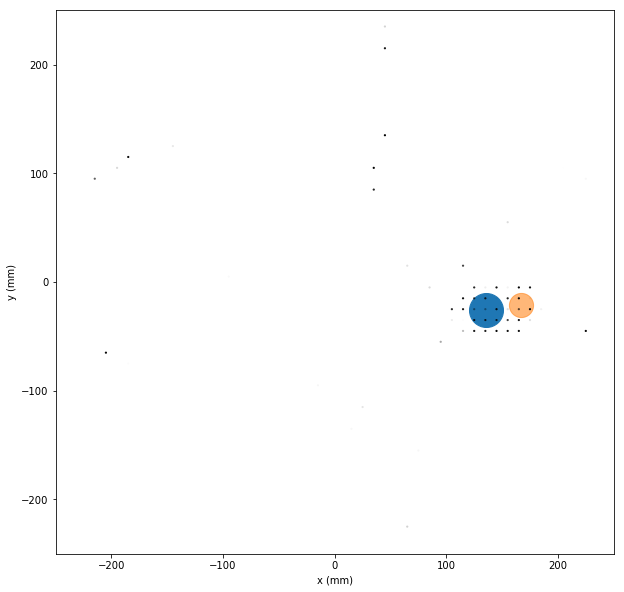

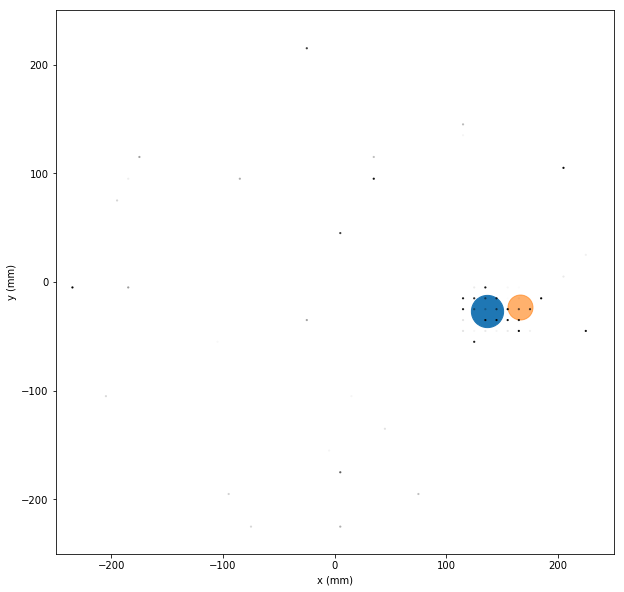

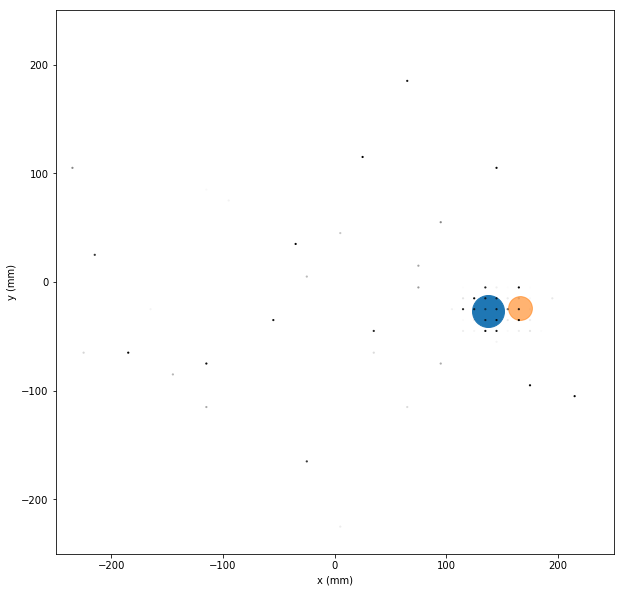

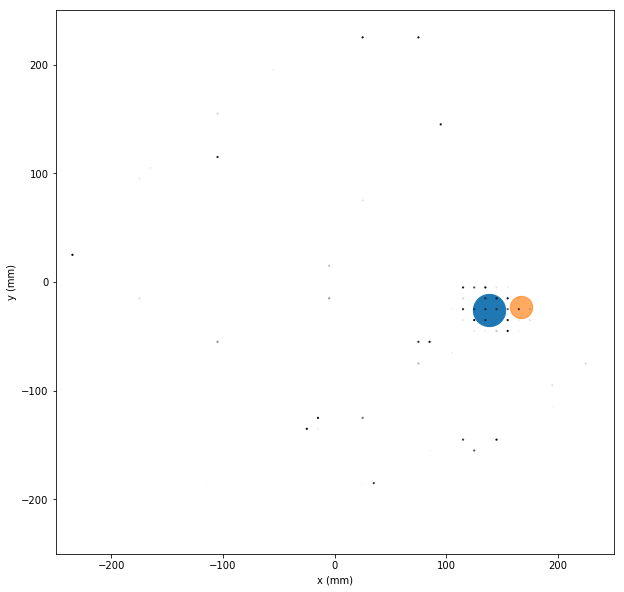

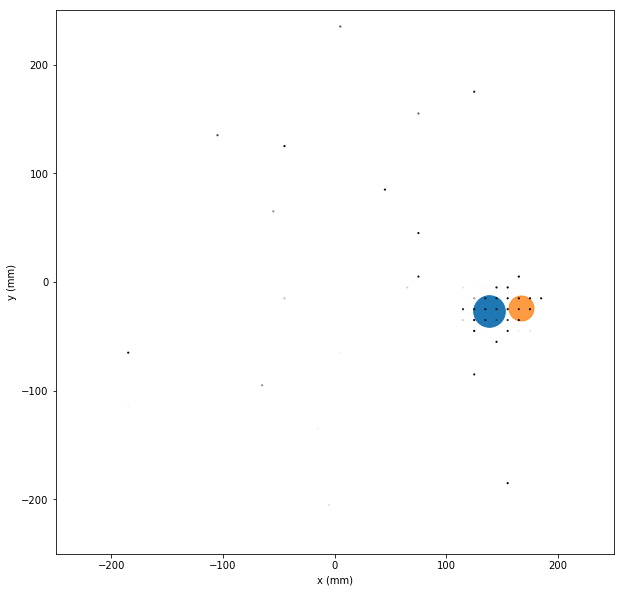

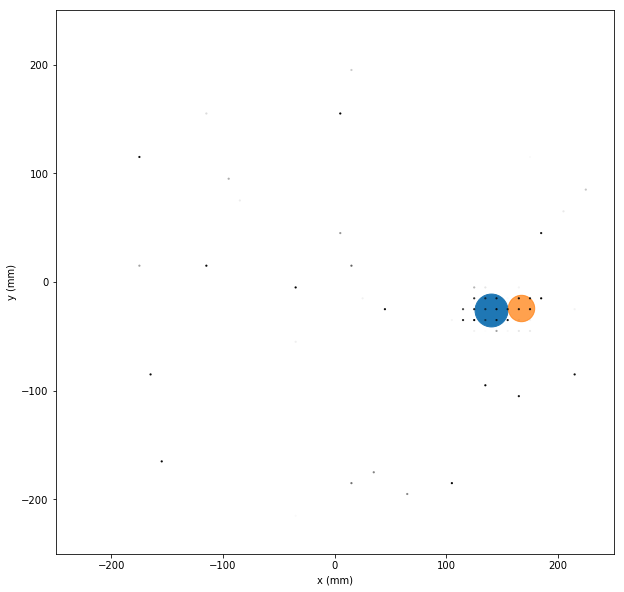

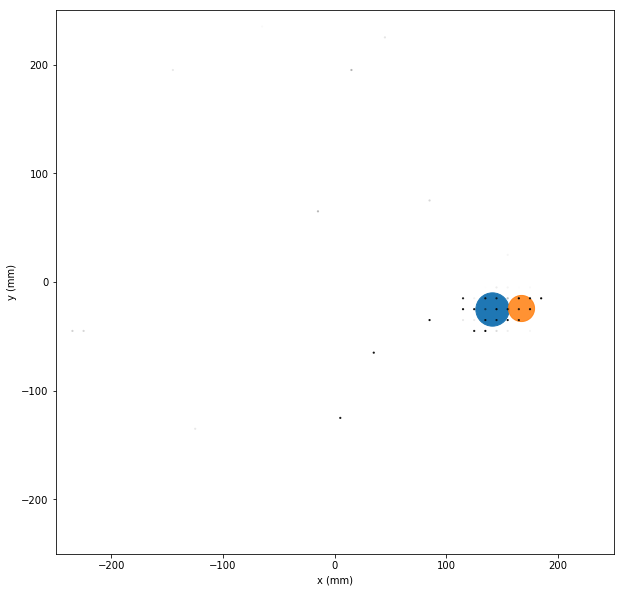

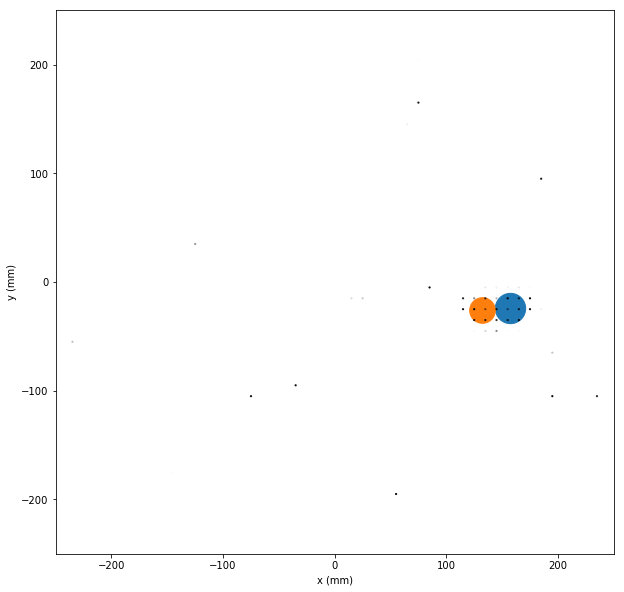

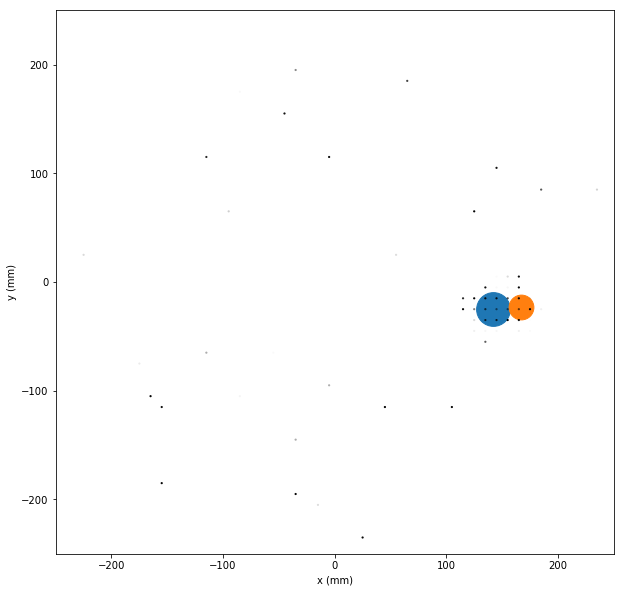

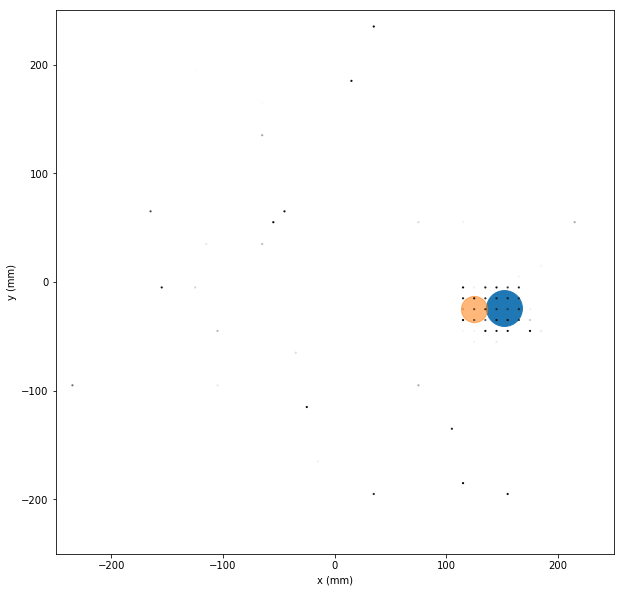

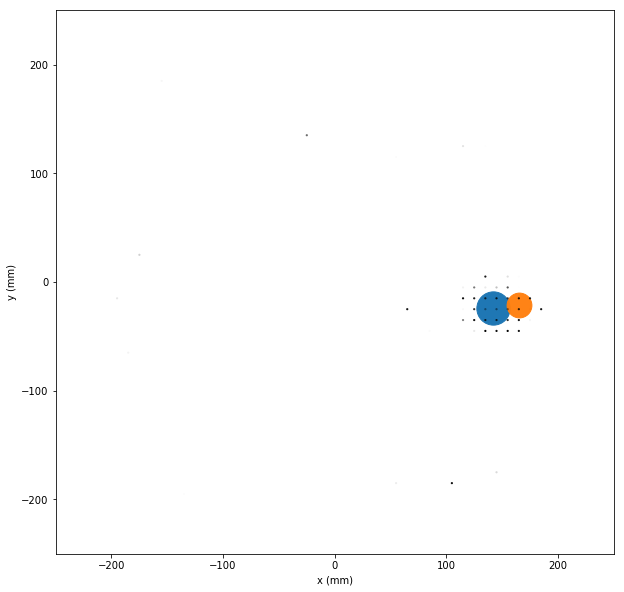

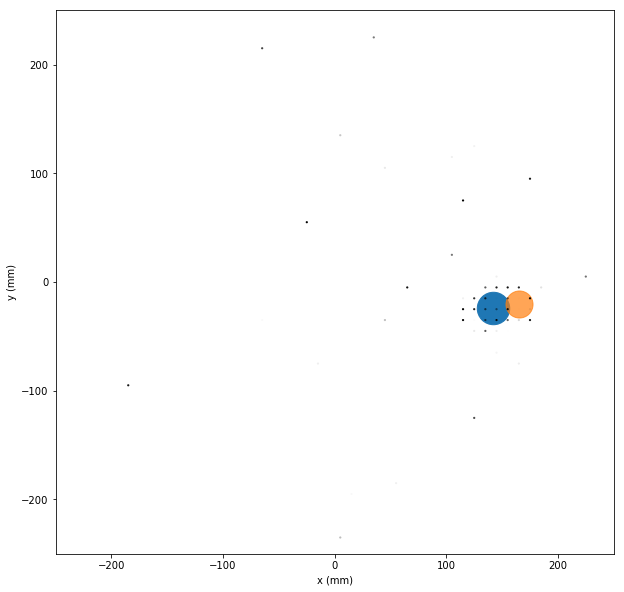

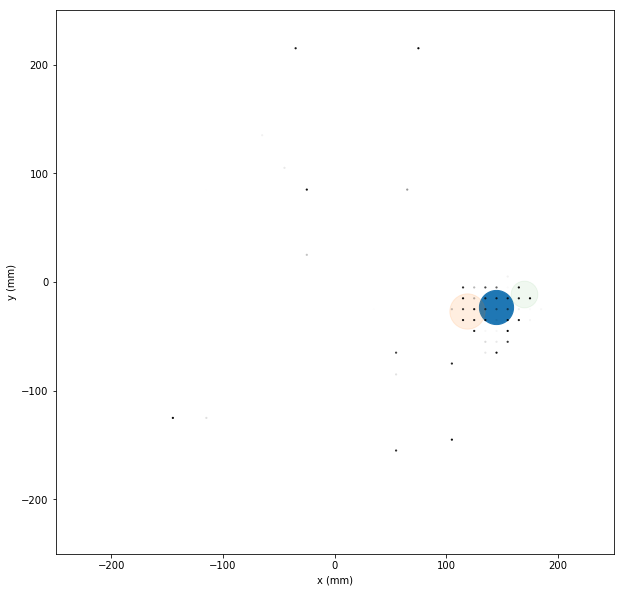

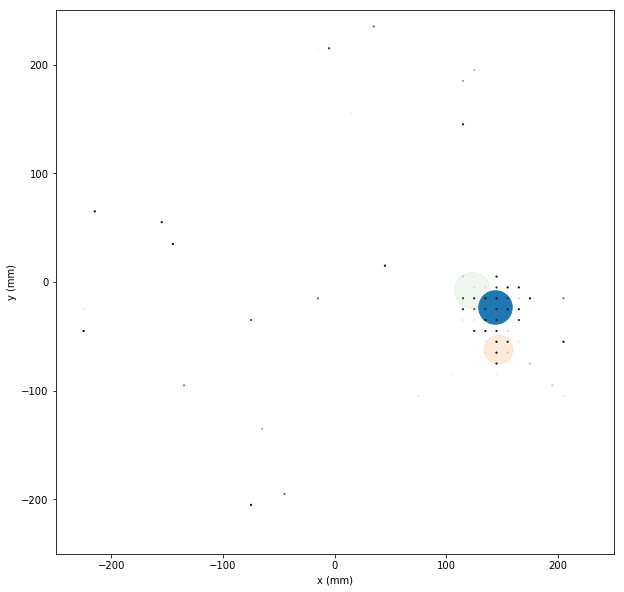

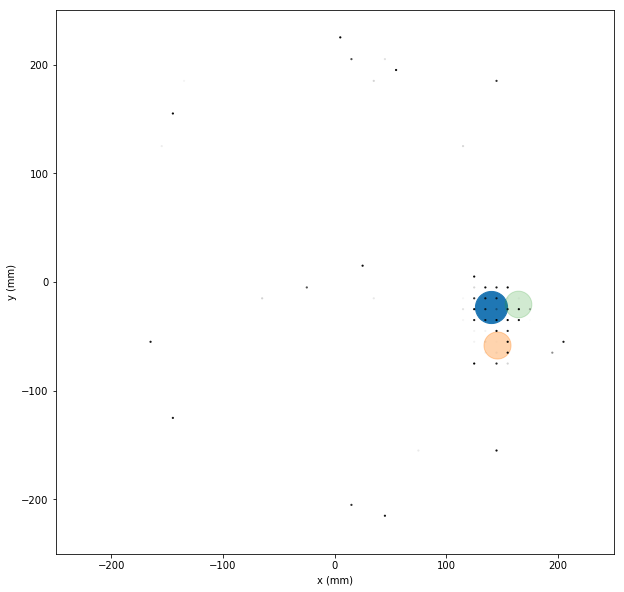

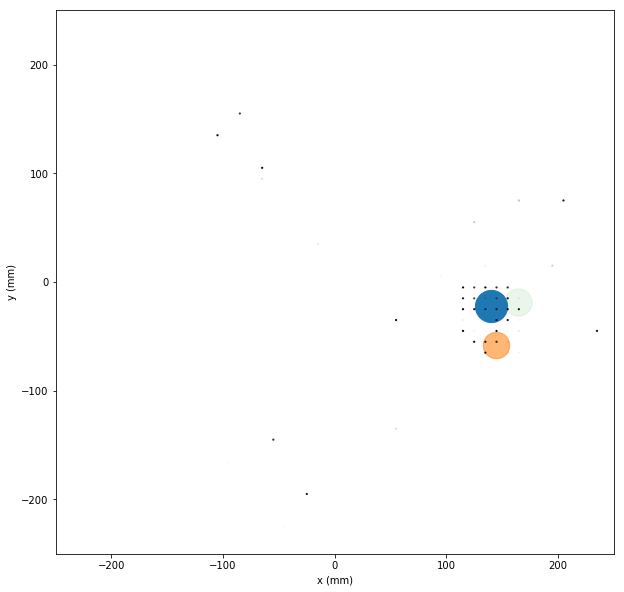

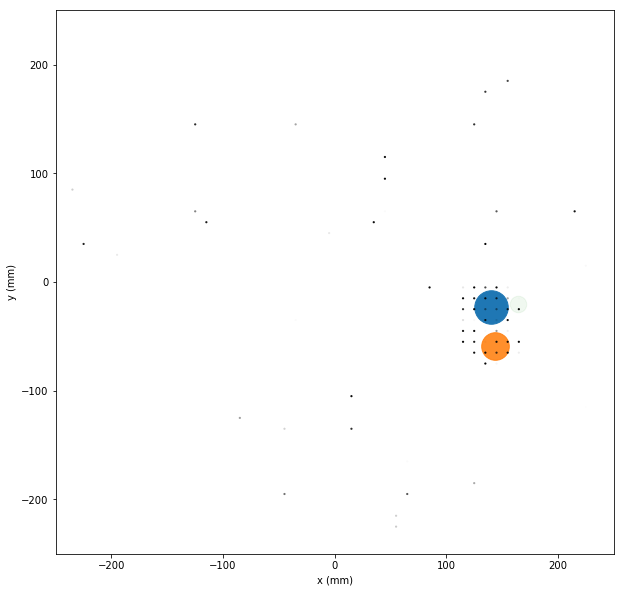

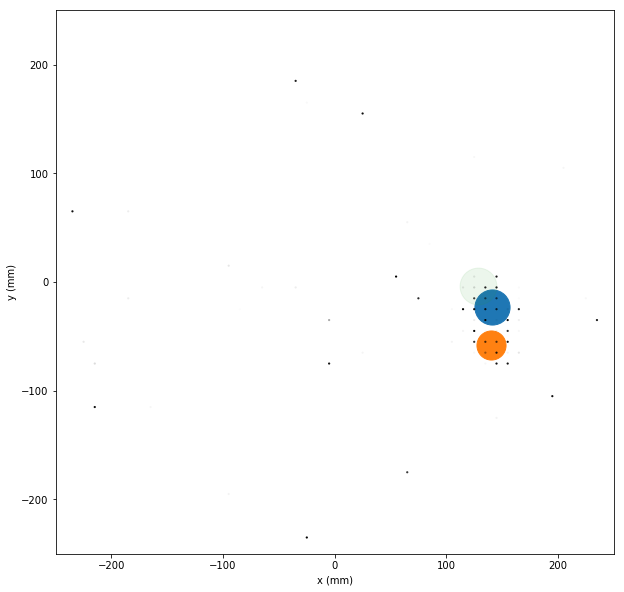

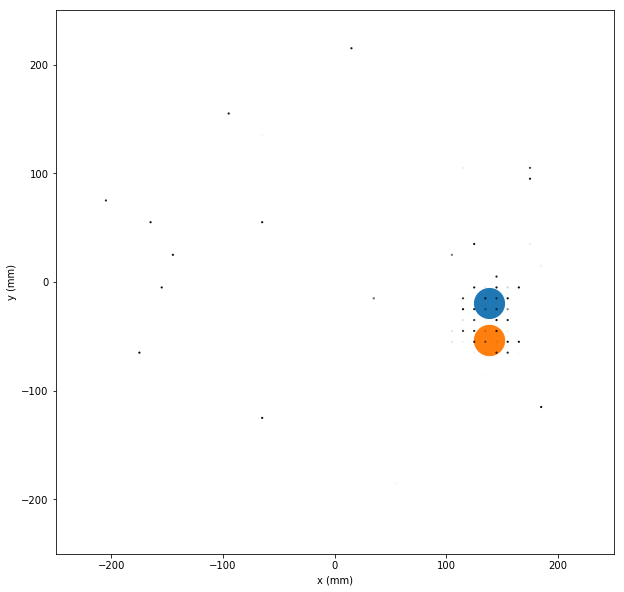

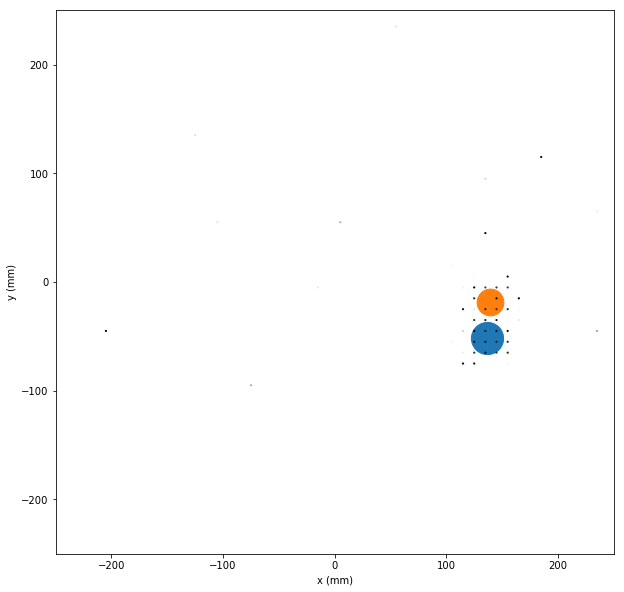

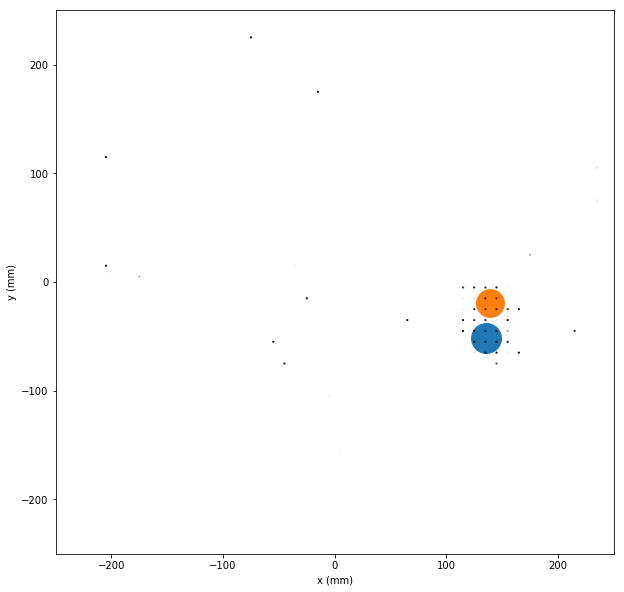

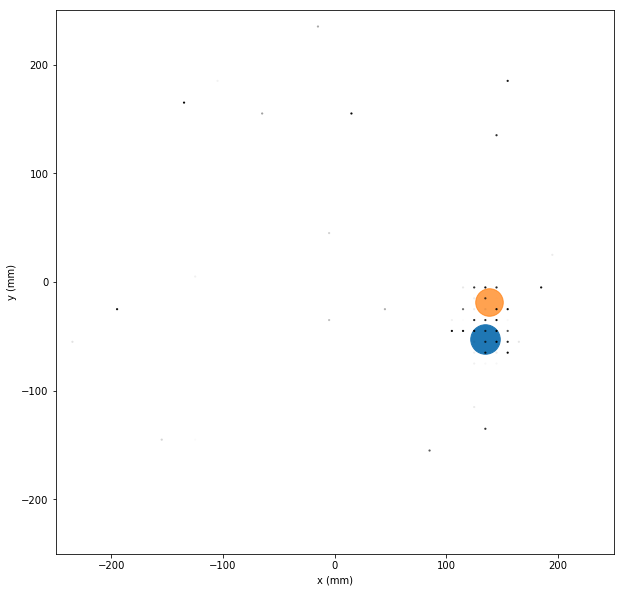

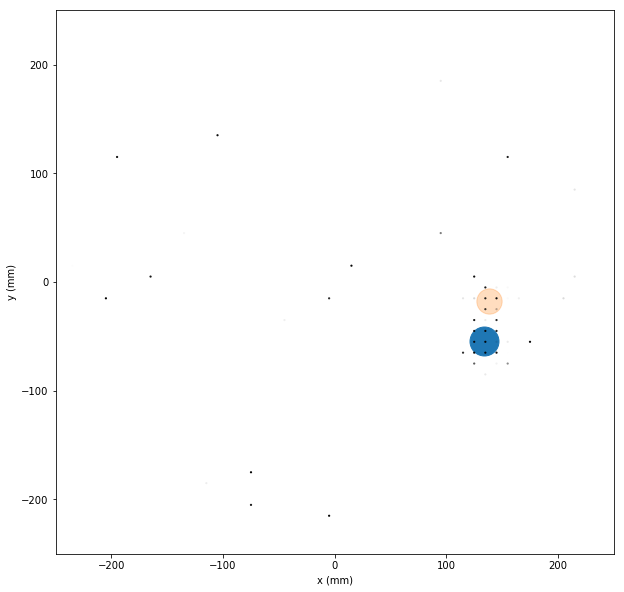

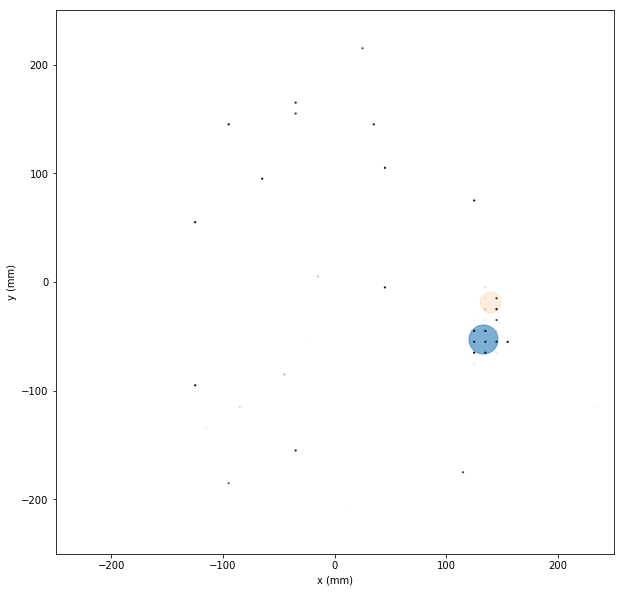

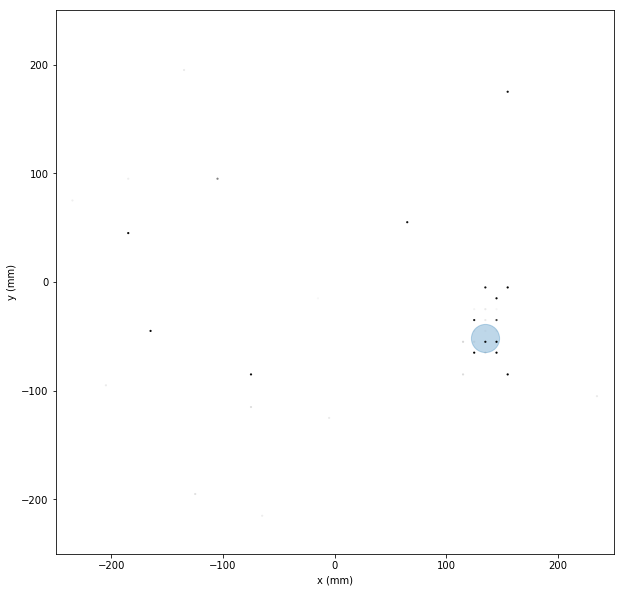

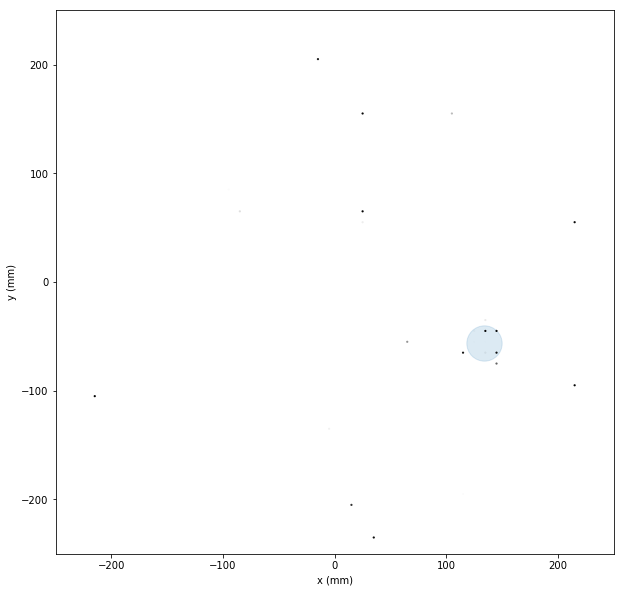

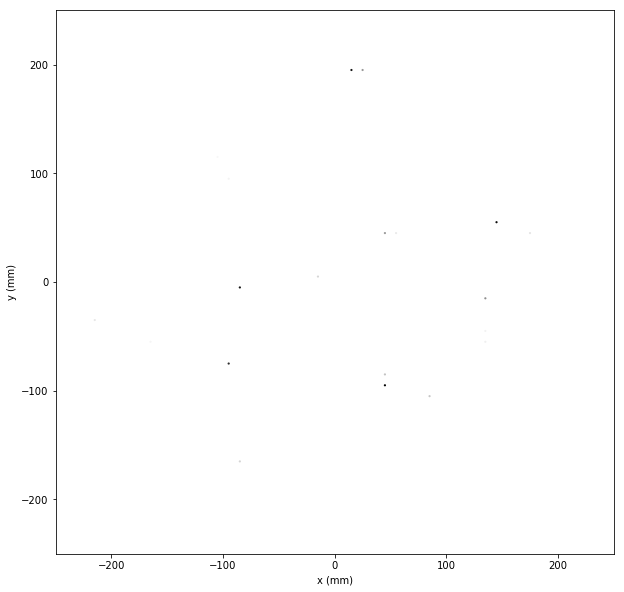

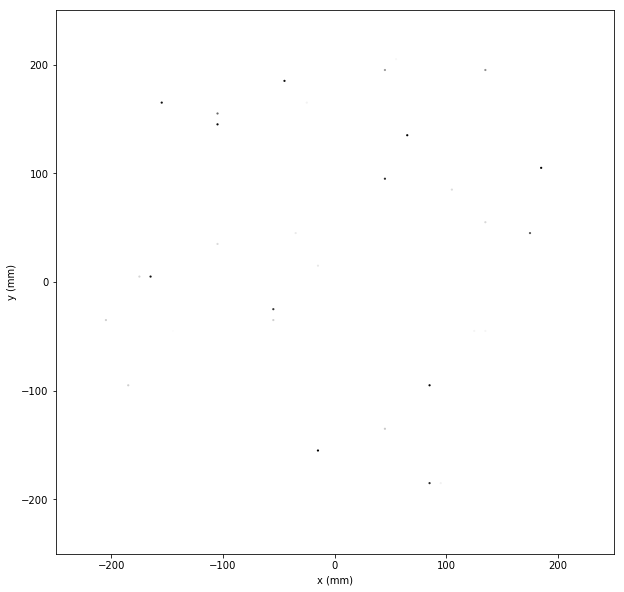

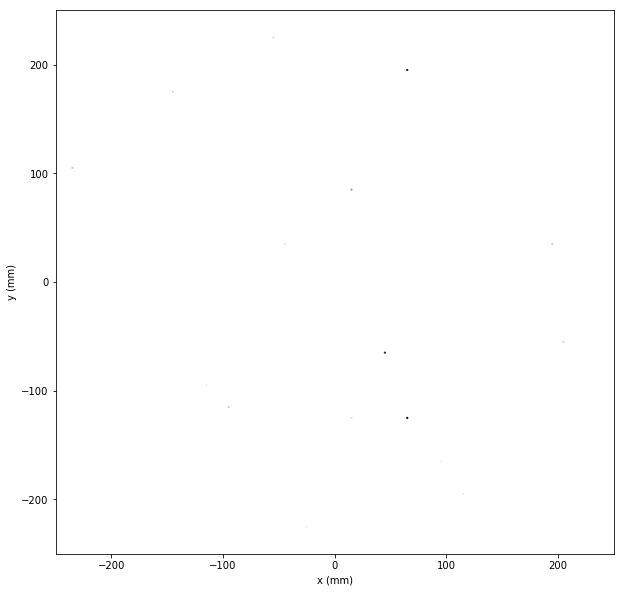

In [19]:
# reconstruct the entire event
e_X = tbl_X[r_evt]
e_Y = tbl_Y[r_evt]
e_T = tbl_T[r_evt]
e_E = tbl_E[r_evt]
e_Q = tbl_Q[r_evt]
#print("Total energy is {0}".format(np.sum(e_E)))


rmax= 25*units.mm
T   = 5*units.pes

# iterate through all slices
for sli, (Xs,Ys,Ts,Es,Qs) in enumerate(zip(e_X,e_Y,e_T,e_E,e_Q)):
    
    hitc = HitCollection()
    hitc.evt   = r_evt
    clusters = corona(Xs,Ys,Qs,rmax=rmax, T=T, msipm=3)
    es       = split_energy(Es, clusters)
    
    if len(clusters) >=0:
        plot_test_event(Xs,Ys,Qs)
        for c in clusters: 
            plt.scatter(c.X,c.Y, 
                        alpha = (min(1, c.Q / 200.0*units.pes)), 
                        s     = ((c.Xrms + c.Yrms))**2*np.pi)
            

